### ECS-171 Group 3 Final Project

# Vehicle Classification

### Importing and Loading Data

In [38]:
import tensorflow as tf
import os # helps to navigate through file directory

In [39]:
import cv2
import imghdr

In [40]:
data_dir = 'data3' 

In [41]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [42]:
# Removes images that dont have these extensions
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

### Preprocessing Data

In [43]:
import numpy as np
from matplotlib import pyplot as plt

In [44]:
# This makes the labels and classes, data pipeline. Also does preprocessing like resizing images
# to 256x256 with 32 batch size
data = tf.keras.utils.image_dataset_from_directory('data3') 

Found 977 files belonging to 5 classes.


In [45]:
# One hot code image labels in classes to use for categorical cross entropy for multi class classification
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=5)  # Assuming 7 classes
    return image, label

In [46]:
# Apply one hot encoding to the dataset
data = data.map(one_hot_encode)

In [47]:
data_iterator = data.as_numpy_iterator() # Loops through the data pipeline, Converted into numpy arrays 

In [48]:
batch = data_iterator.next() # Grabs a batch from the iterator

In [49]:
batch[0].shape # Images represented as numpy arrays  also image labels will be in [1]

(32, 256, 256, 3)

In [50]:
batch[1] # Also labels will be in [1]

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

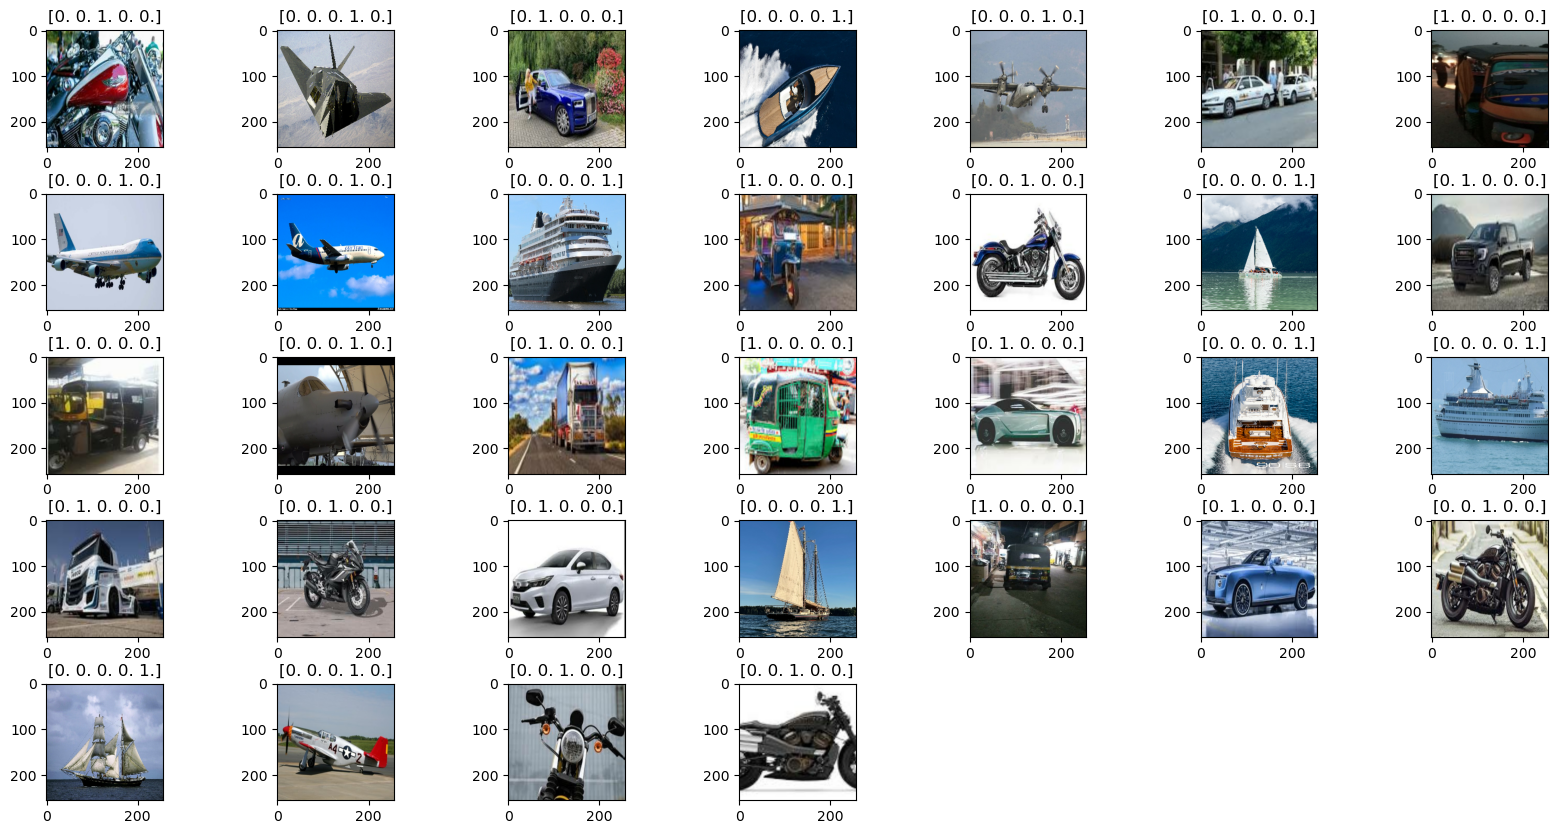

In [51]:
nrows = 5  # Number of rows
ncols = 7  # Number of columns (total images should be nrows * ncols)

# Create the subplots
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

# Flatten the axes array for easy indexing
ax = ax.flatten()

# Loop through the images and plot them
for idx, img in enumerate(batch[0][:nrows * ncols]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(str(batch[1][idx]))

# Remove any empty subplots (if batch[0] contains fewer images than nrows * ncols)
for i in range(len(batch[0]), nrows * ncols):
    fig.delaxes(ax[i])

# Adjust spacing
plt.subplots_adjust(wspace=0.4, hspace=0.4)  


### Scaling Data

In [52]:
# data normalization, converts pixel data to range of 0 to 1
# Improve model performance
data = data.map(lambda x, y: (x/255, y)) # x is image data, y is the label


### Split data

In [53]:
len(data) # number of batches

31

In [54]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)+1

In [55]:
train_size+val_size+test_size

31

In [56]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [57]:
len(train)

24

### Building Classification Model

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

In [59]:
model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3))) 
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))



model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(5, activation='softmax'))

#early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0.000,
                               verbose = 1, 
                               patience = 10, 
                               restore_best_weights = True,
                              )

In [60]:
model.compile(optimizer= 'adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [61]:
hist = model.fit(train, epochs=200, validation_data=val, callbacks = [early_stopping])

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.2201 - loss: 1.6079 - val_accuracy: 0.3333 - val_loss: 1.5629
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.3245 - loss: 1.4527 - val_accuracy: 0.4271 - val_loss: 1.4882
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.5012 - loss: 1.2290 - val_accuracy: 0.5833 - val_loss: 1.0033
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.5915 - loss: 1.0408 - val_accuracy: 0.5938 - val_loss: 1.0664
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.5898 - loss: 1.1008 - val_accuracy: 0.6771 - val_loss: 0.8831
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.7251 - loss: 0.8157 - val_accuracy: 0.7396 - val_loss: 0.6506
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.7714 - loss: 0.6301 - val_accuracy: 0.7708 - val_loss: 0.6516
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.8006 - loss: 0.5723 - val_accu

### Relevant Plots

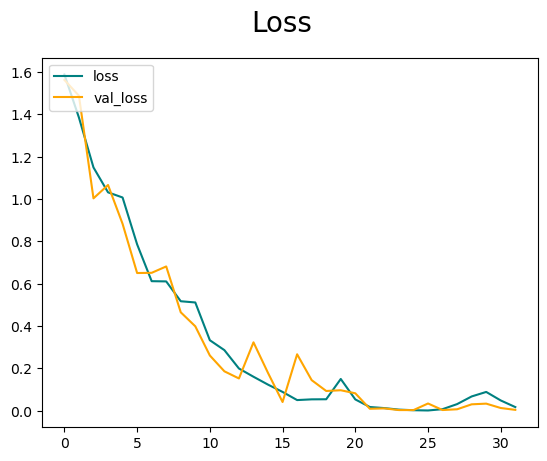

In [62]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

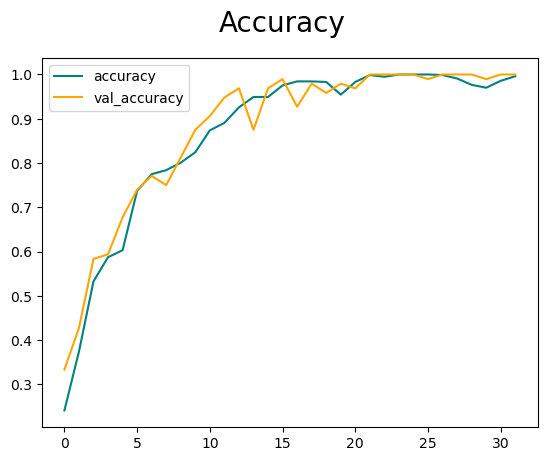

In [63]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Save Model

In [64]:
from tensorflow.keras.models import load_model

In [65]:
model.save(os.path.join('models','cnnmodel4.h5'))

In [66]:
new_model = load_model(os.path.join('models','cnnmodel4.h5'))

### Testing Random Image from Local Device

#### Image from user's local device may be inputted to the model to be classified. Add file name of the image below under the variable "userimg"

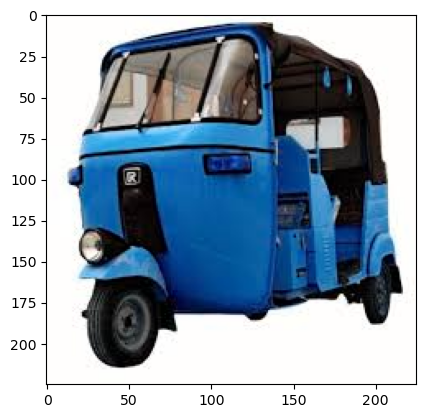

In [105]:
userimg = 'smth7.jpg' #insert file name here, including the file extension
img = cv2.imread(userimg)
plt.imshow(img)
plt.show()

In [106]:
resize = tf.image.resize(img, (256, 256))

In [107]:
resize = resize / 255.0

In [108]:
resize = np.expand_dims(resize, axis=0)

In [109]:
yhat = new_model.predict(resize)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [110]:
predicted_class = np.argmax(yhat)
if predicted_class == 0:
    print("This is a rickshaw")
elif predicted_class == 1:
    print("This is a car")
elif predicted_class == 2:
    print("This is a motorcycle")
elif predicted_class == 3:
    print("This is a plane")
else:
    print("This is a ship")

This is a rickshaw


In [73]:
from sklearn.model_selection import KFold

data = tf.keras.utils.image_dataset_from_directory('data3', batch_size=None) 


def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=5)  
    return image, label

data = data.map(one_hot_encode)

def check_and_fix_shapes(dataset):
    processed_data = []
    for img, lbl in dataset.as_numpy_iterator():
        if img.shape == (256, 256, 3) and lbl.shape == (5,):
            processed_data.append((img, lbl))
        else:
            print(f"skip not expected image，image shape: {img.shape}, lable: {lbl.shape}")

    images, labels = zip(*processed_data)
    return np.array(images), np.array(labels)


processed_images, processed_labels = check_and_fix_shapes(data)

# cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

for train_index, val_index in kf.split(processed_images):
    train_images, val_images = processed_images[train_index], processed_images[val_index]
    train_labels, val_labels = processed_labels[train_index], processed_labels[val_index]
    train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32)
    val_data = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(32)



    print(f'training number {fold_no} fold...')
    history = model.fit(train_data, epochs=10, validation_data=val_data)

    scores = model.evaluate(val_data, verbose=0)
    print(f'number {fold_no} fold score: {model.metrics_names[0]} = {scores[0]}; {model.metrics_names[1]} = {scores[1]}')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no += 1

print('average score of all fold:')
print(f'> accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> loss: {np.mean(loss_per_fold)}')

Found 977 files belonging to 5 classes.
training number 1 fold...
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.8086 - loss: 140.3769 - val_accuracy: 0.8622 - val_loss: 18.6147
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.9200 - loss: 8.4506 - val_accuracy: 0.9439 - val_loss: 9.8805
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.9761 - loss: 1.7957 - val_accuracy: 0.9388 - val_loss: 6.2287
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.9752 - loss: 1.2761 - val_accuracy: 0.9235 - val_loss: 5.9112
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.9747 - loss: 0.7232 - val_accuracy: 0.9439 - val_loss: 4.8281
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.9972 - loss: 0.0257 - val_accuracy: 0.9337 - val_loss: 4.1697
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.9972 - loss: 0.0407 - val_accuracy: 0.9337 - val_loss: 4.7401
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.0194e-09 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.0194e-09 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 3.0194e-09 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 3.0194e-09 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
number 5 fold score: loss = 0.0; compile_metrics = 1.0
average score of all fold:
> accuracy: 97.85661935806274 (+- 2.609206606856178)
> loss: 1.1203092204817584


### Hyperparameter Tuning

In [74]:
#hyperparameter tuning

#importing libraries
import random
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

#hyper parameters
param_acti_func = ['relu', 'sigmoid', 'tanh']
param_filter = [16, 32, 64, 128]
param_layers = [1, 2, 3, 4, 5]

#keeping track of the best parameters
best_params = []
best_acc = 0

#creating general function
def createmodel(acti_func, layers, filter):

    #create the model
    model = Sequential()

    #create hidden layers
    for i in range(layers):
        
        if i == 1:
            model.add(Conv2D(filter[i], (3, 3), 1, activation = acti_func, input_shape = (256,256,3), padding = 'SAME')) 
            model.add(MaxPooling2D(2,2))
        else:
            model.add(Conv2D(filter[i], (3, 3), 1, activation = acti_func, padding = 'SAME')) 
            model.add(MaxPooling2D(2,2))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation=acti_func))
    
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

    return model

#early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor = 'loss',
                               min_delta = 0.000,
                               verbose = 1, 
                               patience = 10, 
                               restore_best_weights = True,
                               start_from_epoch = 30
                              )

#run random search 15 times
for i in range(15):

    #choosing our parameters
    acti_func = random.choice(param_acti_func)
    layers = random.choice(param_layers)
    filter = []
    for j in range(layers):
        filter.append(random.choice(param_filter))

    #creating sample
    sample = []
    sample.append(acti_func)
    sample.append(layers)
    sample.append(filter)

    #create model
    model = createmodel(acti_func, layers, filter)

    #train model
    train_model = model.fit(train, callbacks = [early_stopping])

    test_labels = np.concatenate([y for _, y in test], axis=0)

    #making predictions, this returns a probability
    prediction = model.predict(test)
    
    #return the index of the highest probability
    pred_class = prediction.argmax(axis = 1)
    test_class = test_labels.argmax(axis = 1)
    
    #print samples to keep track and accuracy
    print(f"Parameter set #{i+1}")
    print(f"Activation Function: {acti_func}")
    print(f"Number of layers: {layers}")
    print(f"Number of filters per layer: {filter}")
    acc = accuracy_score(test_class, pred_class)
    print(f"Accuracy for parameter set #{i+1}: {acc}")

    #update best parameters and accuracy if we have found a better one
    if acc > best_acc:
        best_acc = acc
        best_params = sample

print(f"Best Accuracy: {best_acc}")
print(f"Parameters used: {best_params}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 410ms/step - accuracy: 0.2519 - loss: 23.9561
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
Parameter set #1
Activation Function: relu
Number of layers: 1
Number of filters per layer: [16]
Accuracy for parameter set #1: 0.20353982300884957


C:\Users\harri\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.1682 - loss: 3.1900


2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000014FDDEC5D30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step
Parameter set #2
Activation Function: sigmoid
Number of layers: 2
Number of filters per layer: [16, 16]
Accuracy for parameter set #2: 0.168141592920354


C:\Users\harri\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2591 - loss: 5.4321
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step
Parameter set #3
Activation Function: relu
Number of layers: 2
Number of filters per layer: [128, 64]
Accuracy for parameter set #3: 0.23008849557522124


C:\Users\harri\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.2540 - loss: 2.5571
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Parameter set #4
Activation Function: tanh
Number of layers: 4
Number of filters per layer: [16, 16, 128, 16]
Accuracy for parameter set #4: 0.168141592920354


C:\Users\harri\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.2189 - loss: 1.6140
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
Parameter set #5
Activation Function: relu
Number of layers: 4
Number of filters per layer: [64, 16, 32, 32]
Accuracy for parameter set #5: 0.19469026548672566


C:\Users\harri\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.2534 - loss: 2.6375
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
Parameter set #6
Activation Function: relu
Number of layers: 3
Number of filters per layer: [16, 32, 64]
Accuracy for parameter set #6: 0.20353982300884957
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 450ms/step - accuracy: 0.2362 - loss: 3.0168
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Parameter set #7
Activation Function: sigmoid
Number of layers: 1
Number of filters per layer: [16]
Accuracy for parameter set #7: 0.12389380530973451


C:\Users\harri\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.2390 - loss: 4.8817
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
Parameter set #8
Activation Function: tanh
Number of layers: 4
Number of filters per layer: [16, 32, 128, 64]
Accuracy for parameter set #8: 0.26548672566371684
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.2239 - loss: 7.7706
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step
Parameter set #9
Activation Function: tanh
Number of layers: 1
Number of filters per layer: [64]
Accuracy for parameter set #9: 0.25663716814159293


C:\Users\harri\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 590ms/step - accuracy: 0.1996 - loss: 4.9099
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step
Parameter set #10
Activation Function: sigmoid
Number of layers: 3
Number of filters per layer: [64, 32, 128]
Accuracy for parameter set #10: 0.17699115044247787
24/24 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.2096 - loss: 3.6641
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 355ms/step
Parameter set #11
Activation Function: sigmoid
Number of layers: 1
Number of filters per layer: [128]
Accuracy for parameter set #11: 0.1504424778761062


C:\Users\harri\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2080 - loss: 5.8161
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step
Parameter set #12
Activation Function: tanh
Number of layers: 3
Number of filters per layer: [128, 128, 16]
Accuracy for parameter set #12: 0.1592920353982301
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 855ms/step - accuracy: 0.2259 - loss: 3.7604
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
Parameter set #13
Activation Function: sigmoid
Number of layers: 1
Number of filters per layer: [32]
Accuracy for parameter set #13: 0.19469026548672566


C:\Users\harri\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 392ms/step - accuracy: 0.1733 - loss: 5.9156
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
Parameter set #14
Activation Function: tanh
Number of layers: 2
Number of filters per layer: [64, 16]
Accuracy for parameter set #14: 0.19469026548672566


C:\Users\harri\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.2697 - loss: 9.3770
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step
Parameter set #15
Activation Function: relu
Number of layers: 2
Number of filters per layer: [128, 128]
Accuracy for parameter set #15: 0.20353982300884957
Best Accuracy: 0.26548672566371684
Parameters used: ['tanh', 4, [16, 32, 128, 64]]


#### The hyperparameters do not show a significant improvement for the model, thus we have already chosen the ideal hyperparameters for the model.